In [1]:
import pandas as pd
import numpy as np
from hmmlearn import hmm
import matplotlib.pyplot as plt
from pyprojroot import here
import pyro
import pyro.distributions as dist
import pyro.distributions.constraints as constraints
from pyro.infer import SVI, TraceEnum_ELBO
from pyro.optim import Adam
from scipy.stats import poisson
import torch
import seaborn as sns
import collections


data = pd.read_csv(here("data/recent_donations.csv"))
data

# remove columns y_2020 to y_2023
# data = data.drop(columns=["y_2020", "y_2021", "y_2022", "y_2023"])

,unique_number,class_year,birth_year,first_donation_year,gender,y_2009,y_2010,y_2011,y_2012,y_2013,y_2014,y_2015,y_2016,y_2018,y_2019,y_2017,y_2020,y_2021,y_2022,y_2023
0,26308560,"(1960,1970]",1965,1985,M,0,0,0,0,0,0,0,0,0,0,0,1,1,3,1
1,26309283,"(1960,1970]",1966,2002,M,2,1,2,2,1,1,3,3,4,1,3,3,3,3,4
2,26317365,"(1960,1970]",1961,1984,M,4,2,3,3,3,4,3,3,2,3,3,2,0,1,0
3,26318451,"(1960,1970]",1967,1989,M,0,3,3,4,4,4,2,3,3,1,2,3,1,0,0
4,26319465,"(1960,1970]",1964,1994,F,1,2,2,1,2,1,1,0,0,2,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9231,27220599,"(1970,1980]",1980,2022,M,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0
9232,27220806,"(2000,2010]",2002,2022,M,0,0,0,0,0,0,0,0,0,0,0,0,0,2,3
9233,27221247,"(1990,2000]",2000,2022,F,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0
9234,27221274,"(1960,1970]",1966,2022,F,0,0,0,0,0,0,0,0,0,0,0,0,0,2,3


In [2]:
# ------------------------------------------------------------------
# Required libraries
# ------------------------------------------------------------------
import polars as pl
import numpy as np
import torch

# ------------------------------------------------------------------
# 1. Load data into a Polars DataFrame
# ------------------------------------------------------------------
# df = pl.read_csv("file.csv")          # Uncomment if reading from file
df = pl.from_pandas(data)               # Convert from pandas if already in memory

# ------------------------------------------------------------------
# 2. Collect year columns and build the observation matrix [N, T]
# ------------------------------------------------------------------
year_cols = sorted([c for c in df.columns if c.startswith("y_")])
T = len(year_cols)

obs = (
    df.select(year_cols)                # Select y_* columns
      .fill_null(0)                     # Replace NaNs by 0
      .to_numpy()
      .astype(int)                      # Ensure integer type
)

# ------------------------------------------------------------------
# 3. Create fixed covariates per individual
# ------------------------------------------------------------------
df = df.with_columns(
    [
        (pl.col("gender") == "F").cast(pl.Int8).alias("gender_code"),      # 0 = M, 1 = F
        (
            (pl.col("birth_year") - pl.col("birth_year").mean()) /
            pl.col("birth_year").std()
        ).alias("birth_year_norm")                                         # Standardised birth year
    ]
)

birth_year_norm = df["birth_year_norm"].to_numpy()    # Shape [N]
gender_code     = df["gender_code"].to_numpy()        # Shape [N]

# ------------------------------------------------------------------
# 4. Build dynamic covariates (age and COVID dummy)
# ------------------------------------------------------------------
years_num = np.array([int(c[2:]) for c in year_cols])                 # e.g. [2009, …, 2023]
ages      = years_num[None, :] - df["birth_year"].to_numpy()[:, None] # Shape [N, T]
ages_norm = (ages - ages.mean()) / ages.std()                         # Standardised age

covid_years = np.isin(years_num, [2020, 2021, 2022]).astype(float)    # Shape [T]
covid_years = np.tile(covid_years, (df.height, 1))                    # Shape [N, T]

# ------------------------------------------------------------------
# 5. Assemble the full covariate tensor [N, T, 5]
#    Order: birth_year_norm, gender_code, ages_norm, covid_years, const
# ------------------------------------------------------------------
base_cov  = np.stack([birth_year_norm, gender_code], axis=1)          # Shape [N, 2]
base_cov  = np.repeat(base_cov[:, None, :], T, axis=1)                # [N, T, 2]

dyn_cov   = np.stack([ages_norm, covid_years], axis=2)                # [N, T, 2]

const_cov = np.ones((df.height, T, 1), dtype=np.float32)              # Constant term

full_cov  = np.concatenate([base_cov, dyn_cov, const_cov], axis=2)    # [N, T, 5]
cov_names = ["birth_year_norm",
             "gender_code",
             "ages_norm",
             "covid_years",
             "const"]

# ------------------------------------------------------------------
# 6. Convert to PyTorch tensors (optional)
# ------------------------------------------------------------------
obs_torch      = torch.tensor(obs,      dtype=torch.long)
full_cov_torch = torch.tensor(full_cov, dtype=torch.float)

# ------------------------------------------------------------------
# 7. Quick sanity check
# ------------------------------------------------------------------
print("obs       :", obs.shape)        # (N, T)
print("covariates:", full_cov.shape)   # (N, T, 5)
print("order     :", cov_names)        # Confirm column order

obs       : (9236, 15)
covariates: (9236, 15, 5)
order     : ['birth_year_norm', 'gender_code', 'ages_norm', 'covid_years', 'const']


**Purpose**  
Find the most plausible number of hidden states $K$ for a Poisson Hidden Markov Model by comparing cross-validated likelihoods.

**Code flow**  

1. **`positive_param()`**  
   Creates a strictly positive Pyro parameter, then clamps it to the range $[10^{-3},10^{3}]$.

2. **`make_model(K)` – generative process**  
   • Sample initial state probabilities $ \pi \sim \text{Dirichlet}(\mathbf 1) $.  
   • For each row $i$, sample transition probabilities $ \mathbf A_{i\cdot} \sim \text{Dirichlet}(\mathbf 1) $.  
   • Sample Poisson rates $ \lambda_k \sim \text{Gamma}(2,1) $.  
   • For every sequence, enumerate the latent path $z_{0:T-1}$ and draw observations  
     $$y_t \sim \text{Poisson}(\lambda_{z_t})$$  

3. **`make_guide(K)` – variational family**  
   Mean-field Dirichlet / Gamma distributions whose concentration or shape–rate parameters are created by `positive_param()`.

4. **`fit_hmm(K, data)` – training**  
   Runs Stochastic Variational Inference (`TraceEnum_ELBO`) for 1 200 steps, returning  
   • the final ELBO (sign-flipped so *higher* is better) and  
   • a snapshot of all variational parameters.

5. **`heldout_ll(params, test)` – evaluation**  
   Uses the forward algorithm to compute  
   $\log p(\text{test}\mid \mathbb E[\pi],\mathbb E[\mathbf A],\mathbb E[\lambda])$.

6. **Cross-validation loop**  
   For $K = 2,\dots,6$:  
   • perform 5-fold CV,  
   • train on each train split, evaluate on the held-out split,  
   • average ELBO and held-out log-likelihood across folds,  
   • print a summary line.

7. **Model selection**  
   Inspect the held-out log-likelihood curve and pick the smallest $K$ after which improvements level off (the “elbow”).

Held-out log-likelihood rises sharply up to $K = 4$ and then plateaus, so **$K = 4$** is the most reasonable choice.

In [ ]:
import pyro, torch, numpy as np, pyro.distributions as dist
from pyro.infer import SVI, TraceEnum_ELBO
from pyro.optim import ClippedAdam
from sklearn.model_selection import KFold

# ------------------------------------------------------------
#  helper: safe positive parameter
# ------------------------------------------------------------
def positive_param(name, shape, init_val=2.0):
    """
    Creates / fetches a positive param and clamps it in-place
    to avoid 0 or inf.  Shape depends on K, so we pass a lambda
    initialiser to Pyro.
    """
    p = pyro.param(
        name,
        lambda: torch.full(shape, init_val),
        constraint=dist.constraints.positive,
    )
    with torch.no_grad():
        p.data.clamp_(min=1e-3, max=1e3)
    return p

# ------------------------------------------------------------
def make_model(K):
    def model(obs):
        N, T = obs.shape
        
        pi  = pyro.sample("pi",  dist.Dirichlet(torch.ones(K)))
        with pyro.plate("row", K):
            A = pyro.sample("A", dist.Dirichlet(torch.ones(K)))
        lam = pyro.sample("lam",
                          dist.Gamma(2.*torch.ones(K),
                                     1.*torch.ones(K)).to_event(1))

        with pyro.plate("donor", N):
            z = pyro.sample("z0", dist.Categorical(pi),
                            infer={"enumerate": "parallel"})
            for t in pyro.markov(range(T)):
                pyro.sample(f"y_{t}", dist.Poisson(lam[z]), obs=obs[:, t])
                if t < T-1:
                    z = pyro.sample(f"z_{t+1}", dist.Categorical(A[z]),
                                    infer={"enumerate": "parallel"})
    return model

# ------------------------------------------------------------
def make_guide(K):
    def guide(obs):
        positive_param("pi_alpha", (K,),  2.0)
        positive_param("A_alpha",  (K,K), 1.0)
        positive_param("r_alpha",  (K,),  2.0)
        positive_param("r_beta",   (K,),  1.0)

        pyro.sample("pi",  dist.Dirichlet(pyro.param("pi_alpha")))
        with pyro.plate("row", K):
            pyro.sample("A", dist.Dirichlet(pyro.param("A_alpha")))
        pyro.sample("lam", dist.Gamma(pyro.param("r_alpha"),
                                      pyro.param("r_beta")).to_event(1))
    return guide

# ------------------------------------------------------------
def fit_hmm(K, data, n_steps=1200, lr=0.01, seed=0, verbose=True):
    pyro.set_rng_seed(seed)
    pyro.clear_param_store()

    svi = SVI(
        make_model(K),
        make_guide(K),
        ClippedAdam({"lr": lr, "clip_norm": 10.0}),
        TraceEnum_ELBO(max_plate_nesting=1),
    )
    elbo_losses = []
    
    for s in range(n_steps):
        loss = svi.step(data)
        elbo_losses.append(loss)
        if verbose:
            print(f"[{s}] Loss = {loss:.2f}")
    
    elbo = -svi.evaluate_loss(data)          # più alto è meglio

    plt.figure(figsize=(8, 5))
    plt.plot(elbo_losses, label="ELBO negativo")
    plt.xlabel("Iterazioni")
    plt.ylabel("ELBO negativo")
    plt.title("Andamento dell'ELBO negativo durante l'ottimizzazione")
    plt.grid(True)
    plt.show()


    return elbo, {k: v.detach().clone() for k, v in pyro.get_param_store().items()}


# Visualization of the ELBO trend

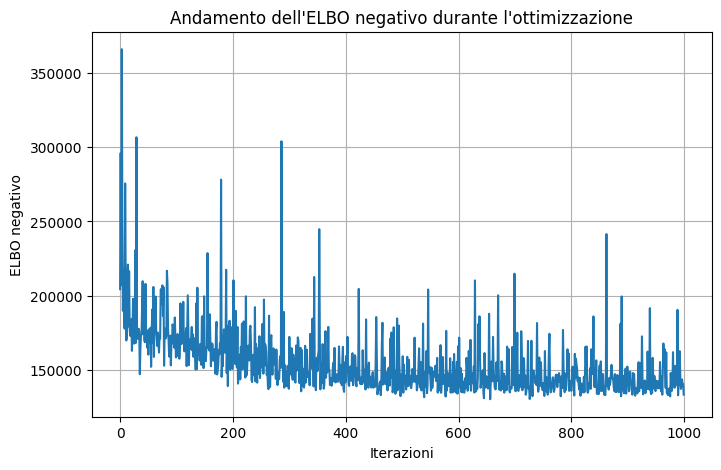

In [8]:
e , p = fit_hmm(4, obs_torch, n_steps=1000, lr=0.01, seed=0, verbose=False)

# Comparison of different number of state

In [ ]:
# function to calculate the log likeliood using the forward algorithm
def log_evidence(params, obs):
    """
    Calcola log p(obs) usando il forward algorithm
    con i parametri appresi (params). E' diverso da 
    EM nel quale i parametri sono aggiornati, qui i parametri sono fissi.
    """
    with torch.no_grad():
        K = params["pi_alpha"].numel()
        
        pi  = dist.Dirichlet(params["pi_alpha"]).mean          # [K]
        A   = dist.Dirichlet(params["A_alpha"]).mean           # [K,K]
        lam = params["r_alpha"] / params["r_beta"]             # [K]

        log_pi = pi.log()                          # log iniziale
        log_A  = (A / A.sum(1, keepdim=True)).log()             # log matrice transizione
        emis   = dist.Poisson(lam).log_prob(obs.unsqueeze(-1))  # (N,T,K) emission log-prob

        N, T = obs.shape
        log_alpha = log_pi + emis[:, 0]                          # inizializzazione

        for t in range(1, T):
            # forward update: logsumexp su dimensione degli stati precedenti
            log_alpha = (log_alpha.unsqueeze(2) + log_A).logsumexp(1) + emis[:, t]

        # log-likelihood sequenze (somma su sequenze)
        total_ll = log_alpha.logsumexp(1).sum().item()
        return total_ll

In [ ]:
# function to compare the scores of ELBO and log-likelihood on multiple models whit different number of states 
def elbo_vs_evidence(obs_data, num_states, num_inits=3, n_steps=1200, lr=0.01, verbose=True):
    best_models = collections.defaultdict(dict)
    best_scores = {
        "log_p(X)": collections.defaultdict(float),
        "elbo":     collections.defaultdict(float),
    }

    for K in num_states:
        best_elbo = float("-inf")
        best_logp = float("-inf")
        best_elbo_params = None
        best_logp_params = None

        for i in range(num_inits):
            seed = i
            elbo, params = fit_hmm(K, obs_data, n_steps=n_steps, lr=lr, seed=seed, verbose=verbose)
            logp = log_evidence(params, obs_data)

            if verbose:
                print(f"Training VI(K={K}, init={i}) ELBO = {elbo:.2f}, log p(X) = {logp:.2f}")

            # Aggiorna miglior modello secondo log p(X)
            if logp > best_logp:
                best_logp = logp
                best_logp_params = params

            # Aggiorna miglior modello secondo ELBO
            if elbo > best_elbo:
                best_elbo = elbo
                best_elbo_params = params

        best_models["log_p(X)"][K] = best_logp_params
        best_models["elbo"][K]     = best_elbo_params
        best_scores["log_p(X)"][K] = best_logp
        best_scores["elbo"][K]     = best_elbo

    return best_models, best_scores

In [ ]:
best_models, best_scores = elbo_vs_evidence(obs_torch, range(2, 7), num_inits=5, verbose=True)

In [ ]:
# Function already defined in previous notebook 
def plot_hmm_params(transitions, initial_probs, emissions,
                        state_names=None, emission_names=None):
        S = len(initial_probs)
        K = emissions.shape[1]
        if state_names is None:
            state_names = [f"State {i}" for i in range(S)]
        if emission_names is None:
            emission_names = [str(i) for i in range(K)]

        fig, axs = plt.subplots(1, 3, figsize=(15, 3))

        # Initial probabilities
        axs[0].bar(np.arange(S), initial_probs, color='royalblue')
        axs[0].set_title('Initial State Probabilities')
        axs[0].set_xlabel('State')
        axs[0].set_ylabel('Probability')
        axs[0].set_xticks(np.arange(S))
        axs[0].set_xticklabels(state_names)
        axs[0].grid(axis='y', alpha=0.3)

        # Transition matrix
        sns.heatmap(transitions, annot=True, fmt=".2f", cmap='Greens',
                    xticklabels=state_names, yticklabels=state_names, ax=axs[1], cbar=False)
        axs[1].set_title('Transition Probabilities')
        axs[1].set_xlabel('Next State')
        axs[1].set_ylabel('Current State')

        # Emission matrix
        sns.heatmap(emissions, annot=True, fmt=".2f", cmap='Blues',
                    xticklabels=emission_names, yticklabels=state_names, ax=axs[2], cbar=False)
        axs[2].set_title('Emission Probabilities')
        axs[2].set_xlabel('Donations in a Year')
        axs[2].set_ylabel('Latent State')

        plt.tight_layout()
        plt.show()

# Plotting the emission probability (Poisson) with learned parameters
def poisson_emission_diagram(lambdas, max_emission=15):
    import numpy as np
    import matplotlib.pyplot as plt

    x_vals = np.arange(max_emission + 1)
    plt.figure(figsize=(8, 5))

    for i, lam in enumerate(lambdas):
        pmf = (np.exp(-lam) * lam ** x_vals) / np.array([np.math.factorial(k) for k in x_vals])
        plt.plot(x_vals, pmf, label=f"State {i}")

    plt.title("Emission Probabilities (Poisson)")
    plt.xlabel("Emission value")
    plt.ylabel("Probability mass")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
# Function to select the best models and print their parameters
def print_best_models(best_models, best_scores):

    for algo, scores in best_scores.items():
        best_score = max(scores.values())
        best_n, _ = max(scores.items(), key=lambda x: x[1])
        metric_name = "Train LL" if algo == "log_p(X)" else "ELBO" if algo == "ELBO" else algo

        print(f"\nBest models for algorithm '{algo}':")
        for n, score in sorted(scores.items()):
            flag = " * <- Best Model" if score == best_score else ""
            print(f"{algo}({n}): {metric_name} = {score:.4f}{flag}")

        print(f"\nBest model for {algo} with K={best_n}, {metric_name} = {best_score:.4f}")
        params = best_models[algo][best_n]

        # Calcola parametri attesi per il plot
        K = params["pi_alpha"].numel()
        pi = torch.distributions.Dirichlet(params["pi_alpha"]).mean.numpy()
        A = torch.distributions.Dirichlet(params["A_alpha"]).mean.numpy()
        lam = (params["r_alpha"] / params["r_beta"]).numpy()

        max_emission = 10
        emission_probs = np.stack([
            torch.distributions.Poisson(l).log_prob(torch.arange(max_emission)).exp().numpy()
            for l in lam
        ])

        # Visualizza i parametri tramite il plot
        plot_hmm_params(A, pi, emission_probs)
        poisson_emission_diagram(lam, max_emission=max_emission)

In [ ]:
# function to penalize the log-likelihood with BIC
def log_evidence_bic(params, obs):
    """
    Calcola la BIC: log p(obs | params) - 1/2 * k * log(n)
    """
    import math

    # Usa la funzione log_evidence per calcolare il log-likelihood totale
    total_log_likelihood = log_evidence(params, obs)

    # Numero osservazioni totali
    N, T = obs.shape
    n = N * T

    # Numero di parametri liberi
    K = params["pi_alpha"].numel()
    k = K + K*K + 2*K  # pi_alpha (K) + A_alpha (K*K) + r_alpha + r_beta (2*K)

    # Calcolo BIC
    bic = total_log_likelihood - 0.5 * k * math.log(n)

    return bic

# Function to plot all scores: Elbo, log likeliood, BIC (wit different number of states) 
def plot_all_scores_and_bic(best_scores, best_models, obs):
    """
    best_scores: dict con punteggi ELBO e log_p(X), es: {'log_p(X)': {K: val}, 'ELBO': {K: val}, ...}
    best_models: dict con i parametri dei modelli
    obs: tensor (N,T) con osservazioni per calcolare il BIC
    """

    Ks = sorted(best_models["log_p(X)"].keys())
    
    # Calcola BIC per ogni K
    bic_values = []
    for K in Ks:
        params = best_models["log_p(X)"][K]
        bic = log_evidence_bic(params, obs)
        bic_values.append(bic)

    plt.figure(figsize=(10, 6))

    # Plot ELBO e log_p(X)
    for algo, scores in best_scores.items():
        Ks_scores = sorted(scores.keys())
        vals = [scores[K] for K in Ks_scores]
        
        if algo == "log_p(X)":
            label = "Train log-likelihood"
            plt.plot(Ks_scores, vals, marker='o', label=label)
        elif algo == "ELBO":
            label = "ELBO"
            plt.plot(Ks_scores, vals, marker='o', label=label)
        else:
            plt.plot(Ks_scores, vals, marker='o', label=algo)

    # Plot BIC: attenzione, BIC è un criterio di penalizzazione, quindi invertiamo la scala
    # per renderlo confrontabile (opzionale)
    plt.plot(Ks, bic_values, marker='o', color='red', linestyle='--', label="BIC (lower is better)")

    plt.xlabel("Number of states K")
    plt.ylabel("Score (higher is better) / BIC (lower is better)")
    plt.title("Model scores and BIC by number of states")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()       


Best models for algorithm 'log_p(X)':
log_p(X)(2): Train LL = -138074.9688
log_p(X)(3): Train LL = -135080.8594
log_p(X)(4): Train LL = -132735.4688
log_p(X)(5): Train LL = -132194.1875 * <- Best Model
log_p(X)(6): Train LL = -132701.7031

Best model for log_p(X) with K=5, Train LL = -132194.1875


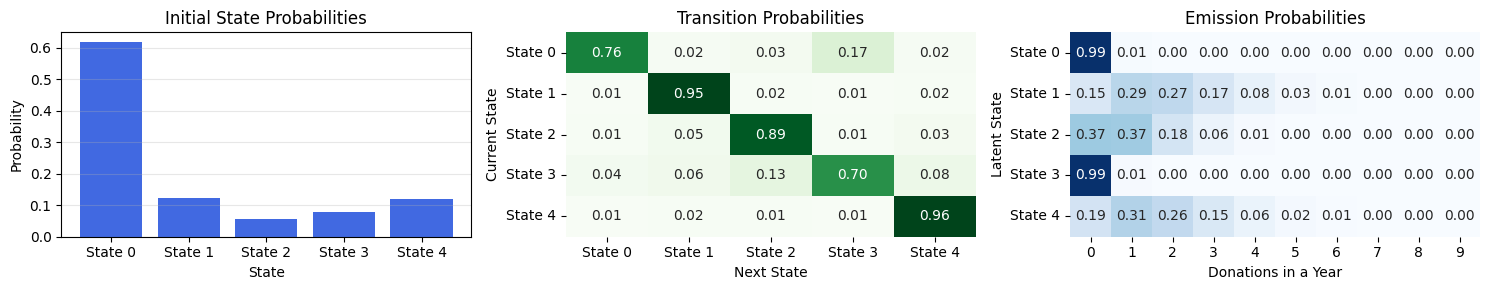

C:\Users\tomma\AppData\Local\Temp\ipykernel_16040\2432859212.py:46: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  pmf = (np.exp(-lam) * lam ** x_vals) / np.array([np.math.factorial(k) for k in x_vals])


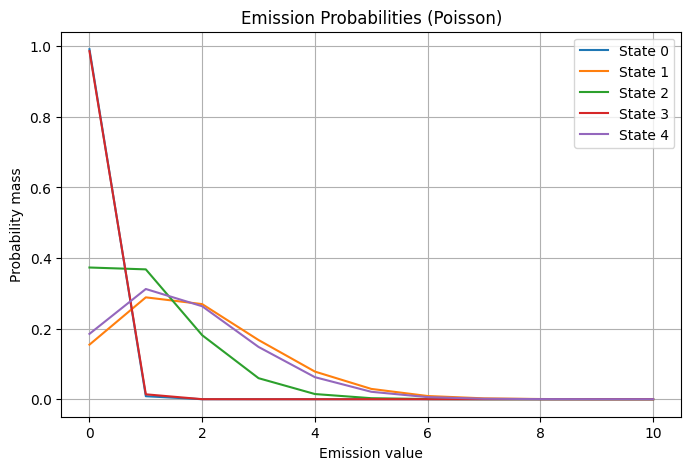


Best models for algorithm 'elbo':
elbo(2): elbo = -140374.6250
elbo(3): elbo = -139162.7031
elbo(4): elbo = -133568.0781
elbo(5): elbo = -135693.2188
elbo(6): elbo = -132776.8125 * <- Best Model

Best model for elbo with K=6, elbo = -132776.8125


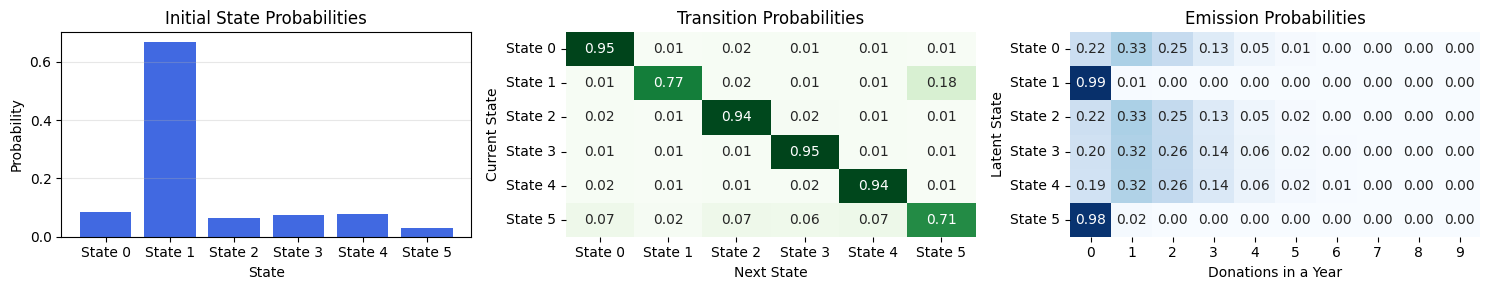

C:\Users\tomma\AppData\Local\Temp\ipykernel_16040\2432859212.py:46: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  pmf = (np.exp(-lam) * lam ** x_vals) / np.array([np.math.factorial(k) for k in x_vals])


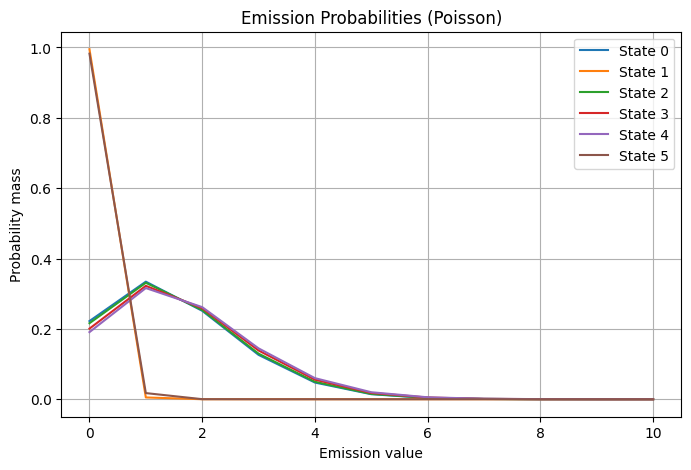

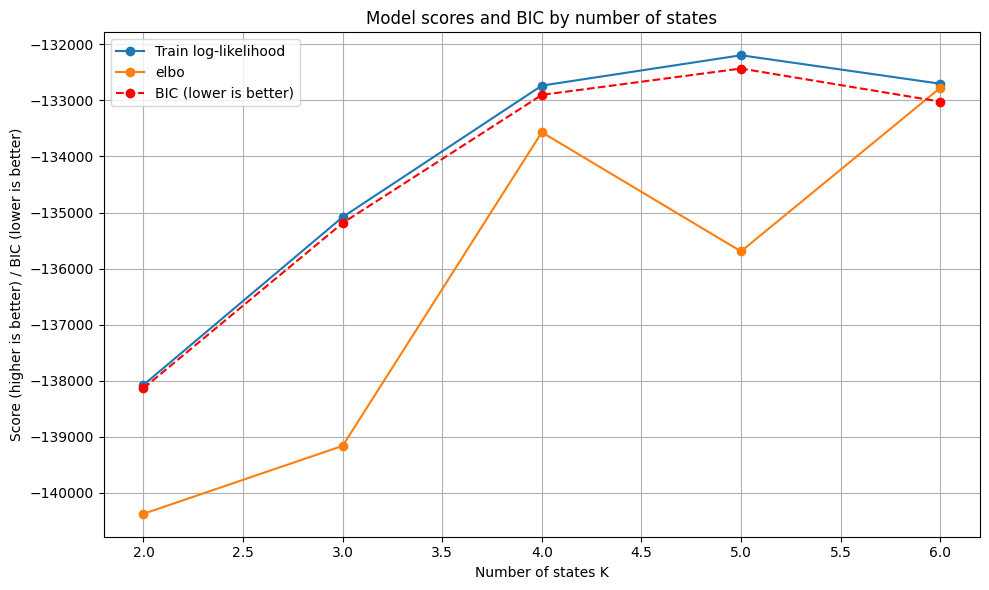

In [ ]:
print_best_models(best_models, best_scores)
plot_all_scores_and_bic(best_scores, best_models, obs_torch)

## PARAMETRI CON EM 

In [36]:
# import numpy as np
# from scipy.special import logsumexp

# def forward(obs, pi, A, lam):
#     T = len(obs)
#     K = len(pi)
#     log_alpha = np.zeros((T, K))
    
#     # log emission probabilities for t=0
#     log_emis = obs[0] * np.log(lam) - lam - np.log(np.math.factorial(obs[0]))
#     log_alpha[0] = np.log(pi) + log_emis

#     for t in range(1, T):
#         log_emis = obs[t] * np.log(lam) - lam - np.log(np.array([np.math.factorial(obs[t])] * K))
#         for j in range(K):
#             log_alpha[t, j] = log_emis[j] + logsumexp(log_alpha[t-1] + np.log(A[:, j]))
#     return log_alpha

# def backward(obs, A, lam):
#     T = len(obs)
#     K = A.shape[0]
#     log_beta = np.zeros((T, K))
#     # Initialization log_beta[T-1] = 0 (log(1))
    
#     for t in reversed(range(T-1)):
#         log_emis = obs[t+1] * np.log(lam) - lam - np.log(np.array([np.math.factorial(obs[t+1])] * K))
#         for i in range(K):
#             log_beta[t, i] = logsumexp(np.log(A[i, :]) + log_emis + log_beta[t+1])
#     return log_beta

# def em_hmm_poisson(obs, K, n_iter=100, tol=1e-4):
#     T = len(obs)

#     # Initialize parameters randomly (or uniform)
#     pi = np.full(K, 1/K)
#     A = np.full((K, K), 1/K)
#     lam = np.random.uniform(0.5, 5, size=K)

#     prev_loglik = -np.inf

#     for iteration in range(n_iter):
#         # E-step: compute forward and backward log probs
#         log_alpha = forward(obs, pi, A, lam)
#         log_beta = backward(obs, A, lam)

#         # Compute log likelihood
#         loglik = logsumexp(log_alpha[-1])
#         if np.abs(loglik - prev_loglik) < tol:
#             print(f"Converged at iteration {iteration}")
#             break
#         prev_loglik = loglik

#         # Compute gamma and xi
#         gamma = np.exp(log_alpha + log_beta - loglik)  # shape (T, K)
#         xi = np.zeros((T-1, K, K))
#         for t in range(T-1):
#             log_emis = obs[t+1] * np.log(lam) - lam - np.log(np.array([np.math.factorial(obs[t+1])] * K))
#             for i in range(K):
#                 for j in range(K):
#                     xi[t, i, j] = log_alpha[t, i] + np.log(A[i, j]) + log_emis[j] + log_beta[t+1, j]
#             xi[t] = np.exp(xi[t] - loglik)

#         # M-step: update parameters
#         pi = gamma[0] / gamma[0].sum()
#         A = xi.sum(axis=0) / xi.sum(axis=(0, 2), keepdims=True).T

#         # Update Poisson lambda
#         lam = (gamma * obs[:, None]).sum(axis=0) / gamma.sum(axis=0)

#     return pi, A, lam, loglik

## CONFRONTO PARAMETRI APPRESI CON VI E EM

# Algoritmo EM per HMM

## Setup

-  $T$ : lunghezza della sequenza osservata  
-  $\mathbf{x} = (x_1, \ldots, x_T)$  sequenza osservata  
- $ K $: numero di stati nascosti  
- $ z_t \in \{1, \ldots, K\} $: stato nascosto al tempo $t$

## Parametri da stimare

- $\pi_i = P(z_1 = i) $ probabilità iniziale dello stato $i$  
- $A_{ij} = P(z_t = j \mid z_{t-1} = i)$ matrice di transizione  
- $B_j(x_t) = P(x_t \mid z_t = j)$ probabilità di emissione (Poisson)


## E-step: calcolo delle distribuzioni posteriori sugli stati latenti

### 1. Forward variables $\alpha(z_n) = (\alpha_1(z_n), ... , \alpha_K(z_n)) $
$
\alpha(z_n) = P(x_n | z_n) \sum_{z_{n-1}} p(z_{n} | z_{n-1}) \alpha(z_{n-1}) 
$
Calcolate ricorsivamente apartire da:

$\alpha(z_1) = P(x_1 | z_1)P(z_1) $


### 2. Backward variables \(\beta_t(i)\)

$
\beta(z_n) = \sum_{z_{n+1}} P(x_{n+1} \mid z_n)  P(z_{n+1} \mid z_n) \beta(z_{n+1})
$

Calcolate ricorsivamente a partire da:

$\beta(z_N) = \mathbf{1} $

### 3. Posteriori sulle singole variabili latenti (\(\gamma_t(i)\))

$
\gamma(z_n) = \frac{\alpha(z_n)\beta(z_n)}{p(\mathbf{x})} \ \ \ \ \psi(z_n) = \frac{\alpha(z_{n-1}) p(x_n \mid z_n) p(z_n \mid z_{n-1}) \beta(z_{n-1})}{p(\mathbf{x})} 
$

con  

$
p(\mathbf{x}) = \sum_{z_n} \alpha(z_n)\beta(z_n) = \sum_{z_N} \alpha(z_N)
$


## M-step: aggiornamento dei parametri

- Aggiornamento $\pi$:

$
\pi^{new} = \gamma(z_1)
$

- Aggiornamento matrice di transizione \(A\):

$
A_{ij}^{new} = \frac{\sum_{n=1}^{N-1} \psi_n(i,j)}{\sum_{t=1}^{T-1} \gamma_n(i)}
$

- Aggiornamento parametri di emissione $B$ (dipende dal modello):

Ad esempio, se $ B_j(x) = P(x \mid z = j) $ è una distribuzione **Poisson** con parametro $\lambda_j$:

$
\lambda_j^{new} = \frac{\sum_{n=1}^N \gamma_n(j) x_t}{\sum_{n=1}^N \gamma_n(j)}
$

In [ ]:
import numpy as np
from scipy.special import logsumexp
from math import factorial
import numpy as np
from scipy.special import logsumexp, factorial

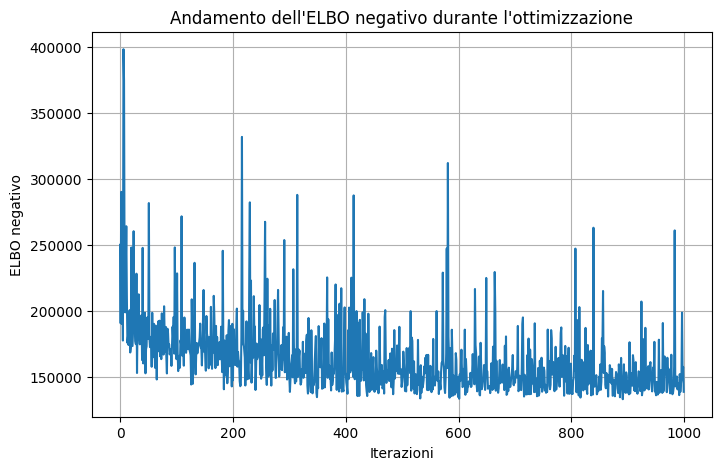

{'pi_alpha': tensor([3.8441, 0.9762, 0.8994]),
 'A_alpha': tensor([[4.7360, 0.6284, 0.4361],
         [0.2893, 7.9186, 0.5164],
         [0.2579, 0.3808, 9.8350]]),
 'r_alpha': tensor([0.3009, 1.8811, 1.6564]),
 'r_beta': tensor([10.1378,  1.0626,  1.2074])}

In [10]:
el , probi = fit_hmm(3, obs_torch, n_steps=1000, lr=0.01, seed=0, verbose=False)
probi

In [ ]:

def forward(obs, pi, A, lam):
    T = len(obs)
    K = len(pi)
    log_alpha = np.zeros((T, K))
    
    # Emission log-probability
    def log_emission(o, lam_k):
        return o * np.log(lam_k) - lam_k - np.log(factorial(o))
    
    # Inizializzazione
    for k in range(K):
        log_alpha[0, k] = np.log(pi[k]) + log_emission(obs[0], lam[k])
    
    # Ricorsione forward
    for t in range(1, T):
        for j in range(K):
            log_alpha[t, j] = log_emission(obs[t], lam[j]) + logsumexp(log_alpha[t-1] + np.log(A[:, j]))
    
    # Calcolo di p(X) = somma su tutti gli stati di alpha_T
    log_p_X = logsumexp(log_alpha[-1])
    
    return log_alpha, log_p_X

def backward(obs, A, lam):
    T = len(obs)
    K = len(A)
    log_beta = np.zeros((T, K))
    
    def log_emission(o, lam_k):
        return o * np.log(lam_k) - lam_k - np.log(factorial(o))
    
    # Inizializzazione
    log_beta[T-1] = 0  # log(1)
    
    # Ricorsione backward
    for t in reversed(range(T-1)):
        for i in range(K):
            log_beta[t, i] = logsumexp(np.log(A[i, :]) + 
                                       [log_emission(obs[t+1], lam[j]) for j in range(K)] + 
                                       log_beta[t+1])
    return log_beta

def compute_gamma_psi(obs, pi, A, lam):
    T = len(obs)
    K = len(pi)
    
    log_alpha = forward(obs, pi, A, lam)
    log_beta = backward(obs, A, lam)
    
    log_pX = logsumexp(log_alpha[T-1])
    
    # Calcolo gamma (T x K)
    log_gamma = log_alpha + log_beta - log_pX
    gamma = np.exp(log_gamma)
    
    # Calcolo psi (T-1 x K x K)
    psi = np.zeros((T-1, K, K))
    for t in range(1, T):
        for i in range(K):
            for j in range(K):
                # log psi numerator
                log_num = (log_alpha[t-1, i] + np.log(A[i, j]) + 
                           obs[t] * np.log(lam[j]) - lam[j] - np.log(factorial(obs[t])) +
                           log_beta[t, j])
                psi[t-1, i, j] = np.exp(log_num - log_pX)
    
    return gamma, psi

def update_parameters_from_gamma_psi(gamma, psi, obs):
    """
    Aggiorna pi, A e lambda (parametri delle Poisson) a partire da gamma e psi.

    Parametri:
    - gamma: array (T, K) delle probabilità posteriori per ogni stato e tempo
    - psi: array (T-1, K, K) delle probabilità congiunte di transizione
    - obs: array (T,) delle osservazioni

    Ritorna:
        pi_new: array (K,) nuova distribuzione iniziale
        A_new: array (K, K) nuova matrice di transizione
        lam_new: array (K,) nuovi tassi di emissione Poisson per stato
    """
    T, K = gamma.shape

    # Aggiorna pi: distribuzione iniziale
    pi_new = gamma[0] / gamma[0].sum()

    # Aggiorna A: matrice di transizione
    numerator = psi.sum(axis=0)  # shape (K, K)
    denominator = numerator.sum(axis=1, keepdims=True)  # shape (K, 1)
    A_new = numerator / denominator

    # Aggiorna lambda: media pesata delle osservazioni
    lam_new = (gamma * obs[:, None]).sum(axis=0) / gamma.sum(axis=0)

    return pi_new, A_new, lam_new

In [ ]:
def hmm_em(obs, K, max_iter=100, tol=1e-4, verbose=False):
    T = len(obs)

    # Inizializzazione casuale dei parametri
    pi = np.random.dirichlet(np.ones(K))
    A = np.random.dirichlet(np.ones(K), size=K)
    lam = np.random.rand(K) * (np.mean(obs) + 1)

    log_likelihoods = []

    for iteration in range(max_iter):
        # E-step
        gamma, psi, log_pX = compute_gamma_psi(obs, pi, A, lam)
        log_likelihoods.append(log_pX)

        # M-step
        pi, A, lam = update_parameters_from_gamma_psi(gamma, psi, obs)

        # Controllo di convergenza
        if iteration > 0 and abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            if verbose:
                print(f"Converged at iteration {iteration}")
            break

    return {
        "pi": pi,
        "A": A,
        "lam": lam,
        "log_likelihoods": log_likelihoods
    }

# Unique joint chain

In [42]:
obs_torch
join_obs = obs_torch.numpy().ravel()


In [43]:
result = hmm_em(join_obs, K=3, max_iter=100, tol=1e-4, verbose=True)


KeyboardInterrupt: 

# One chain at a time, mean

In [22]:
pi_list = []
A_list = []
lam_list = []
p_X_list = []

for i in range(100):
    print(f"Fitting HMM for sequence {i}")
    obs = obs_torch[i].numpy()
    result = hmm_em(obs, K=3, max_iter=100, tol=1e-4, verbose=True)
    
    pi_list.append(result["pi"])
    A_list.append(result["A"])
    lam_list.append(result["lam"])
    p_X_list.append(result["log_likelihoods"][-1])

Fitting HMM for sequence 0


C:\Users\tomma\AppData\Local\Temp\ipykernel_10268\2192432828.py:21: RuntimeWarning: divide by zero encountered in log
  log_alpha[0, k] = np.log(pi[k]) + log_emission(obs[0], lam[k])


Fitting HMM for sequence 1
Converged at iteration 7
Fitting HMM for sequence 2
Converged at iteration 81
Fitting HMM for sequence 3
Converged at iteration 55
Fitting HMM for sequence 4
Converged at iteration 90
Fitting HMM for sequence 5
Converged at iteration 34
Fitting HMM for sequence 6
Converged at iteration 31
Fitting HMM for sequence 7


C:\Users\tomma\AppData\Local\Temp\ipykernel_10268\2192432828.py:24: RuntimeWarning: divide by zero encountered in log
  log_alpha[t, j] = log_emission(obs[t], lam[j]) + logsumexp(log_alpha[t-1] + np.log(A[:, j]))
C:\Users\tomma\AppData\Local\Temp\ipykernel_10268\2192432828.py:34: RuntimeWarning: divide by zero encountered in log
  log_beta[t, i] = logsumexp(np.log(A[i, :]) + emis + log_beta[t+1])
C:\Users\tomma\AppData\Local\Temp\ipykernel_10268\2192432828.py:47: RuntimeWarning: divide by zero encountered in log
  + np.log(A[i, j])


Converged at iteration 57
Fitting HMM for sequence 8
Converged at iteration 99
Fitting HMM for sequence 9
Converged at iteration 6
Fitting HMM for sequence 10
Fitting HMM for sequence 11
Converged at iteration 33
Fitting HMM for sequence 12
Converged at iteration 33
Fitting HMM for sequence 13
Converged at iteration 39
Fitting HMM for sequence 14


C:\Users\tomma\AppData\Local\Temp\ipykernel_10268\2192432828.py:15: RuntimeWarning: divide by zero encountered in log
  return o * np.log(lam_k) - lam_k - np.log(factorial(o))
C:\Users\tomma\AppData\Local\Temp\ipykernel_10268\2192432828.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  return o * np.log(lam_k) - lam_k - np.log(factorial(o))


Fitting HMM for sequence 15
Converged at iteration 34
Fitting HMM for sequence 16
Fitting HMM for sequence 17
Fitting HMM for sequence 18
Fitting HMM for sequence 19
Converged at iteration 52
Fitting HMM for sequence 20
Fitting HMM for sequence 21
Fitting HMM for sequence 22
Converged at iteration 63
Fitting HMM for sequence 23
Converged at iteration 73
Fitting HMM for sequence 24
Fitting HMM for sequence 25
Converged at iteration 86
Fitting HMM for sequence 26
Converged at iteration 17
Fitting HMM for sequence 27
Converged at iteration 60
Fitting HMM for sequence 28
Converged at iteration 99
Fitting HMM for sequence 29
Fitting HMM for sequence 30
Converged at iteration 65
Fitting HMM for sequence 31
Converged at iteration 7
Fitting HMM for sequence 32
Fitting HMM for sequence 33
Fitting HMM for sequence 34
Fitting HMM for sequence 35
Fitting HMM for sequence 36
Converged at iteration 80
Fitting HMM for sequence 37
Fitting HMM for sequence 38
Fitting HMM for sequence 39
Converged at it

In [29]:
pi_list = np.stack(pi_list)       # shape (N, K)
np.nanmean(pi_list, axis=0)        # media probabilità iniziali

array([0.41966039, 0.24961479, 0.33072482])

In [28]:
lam_list = np.stack(lam_list)     # shape (N, K)
np.nanmean(lam_list, axis=0)  # media dei parametri Poisson per ogni stato

array([0.86559813, 0.941979  , 0.84342096])

In [31]:
A_list = np.stack(A_list)         # shape (N, K, K)
np.nanmean(A_list, axis=0)

array([[0.47312306, 0.31952618, 0.20735076],
       [0.22901886, 0.47563392, 0.29534722],
       [0.27974992, 0.26877207, 0.451478  ]])

In [35]:
p_X_list = np.array(p_X_list)  # Converti in numpy array per calcolare la media
np.nansum(p_X_list)  # somma log p(X) per ogni sequenza

-1177.94140362498

In [ ]:
def fit_multiple_hmms(obs_list, K=3, max_iter=100, tol=1e-4, verbose=False):
    """
    Allena un HMM per ogni sequenza in obs_list e calcola le medie dei parametri.

    Parametri:
    - obs_list: lista di array 1D (una sequenza per volta)
    - K: numero di stati nascosti
    - max_iter: massimo numero di iterazioni EM
    - tol: soglia per la convergenza
    - verbose: se True, stampa le informazioni durante il fitting

    Ritorna:
        dict con:
        - 'pi_mean': media delle distribuzioni iniziali
        - 'A_mean': media delle matrici di transizione
        - 'lam_mean': media dei parametri Poisson
        - 'log_likelihood_total': somma dei log-likelihood
        - 'pi_all': tutte le pi stimate (N, K)
        - 'A_all': tutte le A stimate (N, K, K)
        - 'lam_all': tutte le lambda stimate (N, K)
        - 'log_likelihoods': tutti i log p(X)
    """
    pi_list = []
    A_list = []
    lam_list = []
    p_X_list = []

    for i, obs in enumerate(obs_list):
        if verbose:
            print(f"Fitting HMM for sequence {i+1}/{len(obs_list)}")

        try:
            result = hmm_em(obs, K=K, max_iter=max_iter, tol=tol, verbose=verbose)
            pi_list.append(result["pi"])
            A_list.append(result["A"])
            lam_list.append(result["lam"])
            p_X_list.append(result["log_likelihoods"][-1])
        except Exception as e:
            print(f"⚠️  Error fitting sequence {i}: {e}")
            pi_list.append(np.full(K, np.nan))
            A_list.append(np.full((K, K), np.nan))
            lam_list.append(np.full(K, np.nan))
            p_X_list.append(np.nan)

    # Stack e medie ignorando NaN
    pi_all = np.stack(pi_list)        # (N, K)
    A_all = np.stack(A_list)          # (N, K, K)
    lam_all = np.stack(lam_list)      # (N, K)
    log_likelihoods = np.array(p_X_list)

    pi_mean = np.nanmean(pi_all, axis=0)
    A_mean = np.nanmean(A_all, axis=0)
    lam_mean = np.nanmean(lam_all, axis=0)
    log_likelihood_total = np.nansum(log_likelihoods)

    return {
        "pi_mean": pi_mean,
        "A_mean": A_mean,
        "lam_mean": lam_mean,
        "log_likelihood_total": log_likelihood_total,
        "pi_all": pi_all,
        "A_all": A_all,
        "lam_all": lam_all,
        "log_likelihoods": log_likelihoods
    }

In [ ]:
obs_list = [obs_torch[i].numpy() for i in range(100)]

results = fit_multiple_hmms(obs_list, K=3, max_iter=100, tol=1e-4, verbose=True)

print("Media pi:", results["pi_mean"])
print("Media A:", results["A_mean"])
print("Media lambda:", results["lam_mean"])
print("Log-likelihood totale:", results["log_likelihood_total"])